In [1]:
%load_ext rpy2.ipython

In [2]:
%%R

#install.packages("tibble")
#install.packages("dplyr")
#install.packages(ggplot2)
#install.packages("caret")
#install.packages("glmnet")

library(tibble)
library(dplyr)
library(ggplot2)
library(caret)
library(pROC)
library(ROSE)
library(glmnet)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loaded ROSE 0.0-4

Loading required package: Matrix
Loaded glmnet 4.1-8
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [3]:
%%R

binary_driving_mode <- function (df_chassis) {
    result <- ifelse(df_chassis$drivingMode == "COMPLETE_AUTO_DRIVE", 1, 0)

    return(result)
}


merge_chassis_pose <- function (df_chassis, df_pose) {
    
    
    df_chassis <- df_chassis[order(df_chassis$time), ]
    df_pose <- df_pose[order(df_pose$time), ]
    
    #make sure data is sorted by time fist

    chassis_time_arr <- df_chassis$time
    pose_time_arr <- df_pose$time

    matched_vector <- c()

    for (chassis_time in chassis_time_arr) {
        abs_time_diff_arr <- abs(pose_time_arr - chassis_time)

        min_index <-  which(abs_time_diff_arr == min(abs_time_diff_arr))
        
        matched_vector <-  c(matched_vector, pose_time_arr[min_index])
    }



    #df_chassis$matched <- df_pose$time[which(abs(pose_time_arr - df_chassis$time) == min(abs(pose_time_arr - df_chassis$time)))]
    df_chassis$matched <-  matched_vector
    df_pose$matched <-  df_pose$time


    return (list(df_chassis = df_chassis, df_pose = df_pose))


}

latlongStdDev <- function(df_pose){
    x <- df_pose["latitudeStdDev"]
    y <- df_pose["longitudeStdDev"]
        r <- sqrt(x^2 + y^2)

    return(r)

}

In [4]:
%%R
# Defining GMIDs for Red Routes
# Am creating a list of GMIDs for processing
blue_route_gmIDs  <- c(
    '7228e03a-ebf0-11ee-b297-3b0ad9d5d6c6',
'17876fec-ea66-11ee-b297-3b0ad9d5d6c6',
'd1d090d4-ea7c-11ee-b297-3b0ad9d5d6c6',
'ed7f2038-ea1e-11ee-b297-3b0ad9d5d6c6',
'6af236d6-d98f-11ee-a158-97f8443fd730',
'64737d98-d312-11ee-b437-336917683bb8',
'5240e750-ec30-11ee-b297-3b0ad9d5d6c6',
'7613801a-edcb-11ee-9385-ef789ffde1d3',
'68c289fa-dbd4-11ee-a158-97f8443fd730',
'76683d3c-db18-11ee-a158-97f8443fd730',
'69ab88ec-dc17-11ee-a158-97f8443fd730',
'7f09f6c6-a5b0-11ee-88ec-eb6a8d5269b4',
'3d2a80f0-ec81-11ee-b297-3b0ad9d5d6c6',
'feaf2ba8-d28d-11ee-b437-336917683bb8',
'e2079a78-dc1d-11ee-a158-97f8443fd730',
'b224ef9c-ec10-11ee-b297-3b0ad9d5d6c6',
'ba28b352-ec8f-11ee-b297-3b0ad9d5d6c6',
'59c189d8-ed54-11ee-9385-ef789ffde1d3',
'2d35c522-eba2-11ee-b297-3b0ad9d5d6c6',
'3343fd3c-eb87-11ee-b297-3b0ad9d5d6c6',
'c0624e24-d9aa-11ee-a158-97f8443fd730',
'a253145a-d2a6-11ee-b437-336917683bb8',
'9830d896-d2dc-11ee-b437-336917683bb8',
'aa86a660-dc05-11ee-a158-97f8443fd730',
'90101c36-a621-11ee-88ec-eb6a8d5269b4',
'82d39c74-ea59-11ee-b297-3b0ad9d5d6c6',
'f9d62032-db2a-11ee-a158-97f8443fd730',
'af10e22a-ebb1-11ee-b297-3b0ad9d5d6c6',
'47561998-d9c3-11ee-a158-97f8443fd730',
'64875cc0-d054-11ee-9435-f7e542e2436c',
'df8e3742-ec54-11ee-b297-3b0ad9d5d6c6',
'3a2a78cc-db21-11ee-a158-97f8443fd730',
'2bc6ebb8-a529-11ee-88ec-eb6a8d5269b4',
'4d0254fc-ec73-11ee-b297-3b0ad9d5d6c6',
'dc39aa14-db32-11ee-a158-97f8443fd730',
'25d3bdc8-ecbc-11ee-b297-3b0ad9d5d6c6',
'8b6a6cfc-ed6d-11ee-9385-ef789ffde1d3',
'e6d7d384-db40-11ee-a158-97f8443fd730',
'a17c1280-ea10-11ee-b297-3b0ad9d5d6c6',
'36663b02-ea87-11ee-b297-3b0ad9d5d6c6',
'71a18322-ecab-11ee-b297-3b0ad9d5d6c6',
'cf6fdf3a-eaa3-11ee-b297-3b0ad9d5d6c6',
'57d240d6-ea4d-11ee-b297-3b0ad9d5d6c6',
'baf0e4be-bede-11ee-835b-599066b5eb60',
'530de03a-ed79-11ee-9385-ef789ffde1d3',
'43914d48-ed85-11ee-9385-ef789ffde1d3',
'a7c98b32-ebc2-11ee-b297-3b0ad9d5d6c6',
'fc119dfc-eb67-11ee-b297-3b0ad9d5d6c6',
'c7c02bda-ebe0-11ee-b297-3b0ad9d5d6c6',
'39ba7438-d0d5-11ee-9435-f7e542e2436c',
'e8a8b2be-edbf-11ee-9385-ef789ffde1d3',
'3ea96640-ea37-11ee-b297-3b0ad9d5d6c6',
'21376e38-ec01-11ee-b297-3b0ad9d5d6c6',
'513a670c-eea9-11ee-9385-ef789ffde1d3',
'06cbdbc0-db4d-11ee-a158-97f8443fd730',
'559495ca-d270-11ee-b437-336917683bb8',
'04151804-ec20-11ee-b297-3b0ad9d5d6c6',
'd62ee6e8-ed02-11ee-9385-ef789ffde1d3',
'154fab12-a43f-11ee-88ec-eb6a8d5269b4',
'58263e34-a45c-11ee-88ec-eb6a8d5269b4',
'acd71bc0-ecf4-11ee-9385-ef789ffde1d3',
'3441fc36-ecca-11ee-b297-3b0ad9d5d6c6',
'f671c05c-a5e4-11ee-88ec-eb6a8d5269b4',
'c8f54ac0-ebd2-11ee-b297-3b0ad9d5d6c6',
'326699c2-ecd8-11ee-b297-3b0ad9d5d6c6',
'3ce8a358-edd8-11ee-9385-ef789ffde1d3',
'286c70cc-d2f7-11ee-b437-336917683bb8',
'20cbfe8c-ea2b-11ee-b297-3b0ad9d5d6c6',
'c9023e32-ed90-11ee-9385-ef789ffde1d3',
'f0bcec4e-ed3e-11ee-9385-ef789ffde1d3',
'd94ef300-ed60-11ee-9385-ef789ffde1d3',
'e269948a-ed9d-11ee-9385-ef789ffde1d3',
'f6ac3c82-a445-11ee-88ec-eb6a8d5269b4',
'80340ab8-d054-11ee-9435-f7e542e2436c',
'b76f33be-ea61-11ee-b297-3b0ad9d5d6c6',
'da853e0c-a10f-11ee-981c-d126ddbe9afa',
'19b7ebd0-d9b7-11ee-a158-97f8443fd730',
'cb205756-ec43-11ee-b297-3b0ad9d5d6c6',
'64bbe8e0-eb94-11ee-b297-3b0ad9d5d6c6',
'e9d67bf2-ec35-11ee-b297-3b0ad9d5d6c6'
)

In [5]:
%%R
# Initialize an empty tibble
df_merged <- tibble()

# Loop through each gmID
for (id in blue_route_gmIDs) {
  print(id)
  
  # Update the file paths with the correct full paths
  temp_chassis_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_canbus_chassis/%s_apollo_canbus_chassis.csv",
    id, id
  )
  temp_pose_path <- sprintf(
    "/home/gampadu_linux/Desktop/TDMprivate/data/%s/_apollo_sensor_gnss_best_pose/%s_apollo_sensor_gnss_best_pose.csv",
    id, id
  )

  # Check if the files exist
  if (file.exists(temp_chassis_path) && file.exists(temp_pose_path)) {
    # Read the files
    temp_chassis <- as_tibble(read.csv(temp_chassis_path))
    temp_pose <- as_tibble(read.csv(temp_pose_path))
    
    # Process the data
    r <- latlongStdDev(temp_pose)
    temp_pose["latlongStdDev"] <- r
    
    results <- merge_chassis_pose(temp_chassis, temp_pose)
    result_full <- merge(results$df_chassis, results$df_pose, by = "matched")
    
    # Add binary driving mode
    result_full$binaryDrivingMode <- binary_driving_mode(result_full)
    
    # Append to df_merged
    df_merged <- bind_rows(df_merged, result_full)
  } else {
    warning(sprintf("Files not found for gmID: %s", id))
  }
}

print("Done loading data")

[1] "7228e03a-ebf0-11ee-b297-3b0ad9d5d6c6"
[1] "17876fec-ea66-11ee-b297-3b0ad9d5d6c6"
[1] "d1d090d4-ea7c-11ee-b297-3b0ad9d5d6c6"
[1] "ed7f2038-ea1e-11ee-b297-3b0ad9d5d6c6"
[1] "6af236d6-d98f-11ee-a158-97f8443fd730"
[1] "64737d98-d312-11ee-b437-336917683bb8"
[1] "5240e750-ec30-11ee-b297-3b0ad9d5d6c6"
[1] "7613801a-edcb-11ee-9385-ef789ffde1d3"
[1] "68c289fa-dbd4-11ee-a158-97f8443fd730"
[1] "76683d3c-db18-11ee-a158-97f8443fd730"
[1] "69ab88ec-dc17-11ee-a158-97f8443fd730"
[1] "7f09f6c6-a5b0-11ee-88ec-eb6a8d5269b4"
[1] "3d2a80f0-ec81-11ee-b297-3b0ad9d5d6c6"
[1] "feaf2ba8-d28d-11ee-b437-336917683bb8"
[1] "e2079a78-dc1d-11ee-a158-97f8443fd730"
[1] "b224ef9c-ec10-11ee-b297-3b0ad9d5d6c6"
[1] "ba28b352-ec8f-11ee-b297-3b0ad9d5d6c6"
[1] "59c189d8-ed54-11ee-9385-ef789ffde1d3"
[1] "2d35c522-eba2-11ee-b297-3b0ad9d5d6c6"
[1] "3343fd3c-eb87-11ee-b297-3b0ad9d5d6c6"
[1] "c0624e24-d9aa-11ee-a158-97f8443fd730"
[1] "a253145a-d2a6-11ee-b437-336917683bb8"
[1] "9830d896-d2dc-11ee-b437-336917683bb8"
[1] "aa86a6

In [6]:
%%R
# Load required library
library(dplyr)

# Split GMIDs into Training and Testing Sets
training_gmIDs <- blue_route_gmIDs[1:75]  # First 77 GMIDs (80%)
testing_gmIDs <- blue_route_gmIDs[76:80] # Last 5 GMIDs

# Filter df_merged for training and testing data based on GMIDs
train_data <- df_merged %>% filter(groupMetadataID.x %in% training_gmIDs)
test_data <- df_merged %>% filter(groupMetadataID.x %in% testing_gmIDs)

# Check the number of rows in each dataset
print(paste("Training data rows:", nrow(train_data)))
print(paste("Testing data rows:", nrow(test_data)))

# Verify if test_data is not empty
if (nrow(test_data) == 0) {
  print("Error: test_data is empty. Check GMID filtering.")
}

[1] "Training data rows: 4272950"
[1] "Testing data rows: 231479"


In [7]:
%%R
# Train a Logistic Regression Model
model <- glm(
  binaryDrivingMode ~ speedMps + throttlePercentage + brakePercentage + steeringPercentage + latlongStdDev,
  data = train_data,
  family = binomial
)

summary(model)


Call:
glm(formula = binaryDrivingMode ~ speedMps + throttlePercentage + 
    brakePercentage + steeringPercentage + latlongStdDev, family = binomial, 
    data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3598  -0.7777   0.4803   0.6799   2.0494  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.569e+00  3.467e-03 -452.68   <2e-16 ***
speedMps            2.056e-01  2.546e-04  807.54   <2e-16 ***
throttlePercentage  2.507e-02  1.474e-04  170.04   <2e-16 ***
brakePercentage     4.403e-02  1.213e-04  362.87   <2e-16 ***
steeringPercentage -4.752e-03  9.972e-05  -47.66   <2e-16 ***
latlongStdDev       3.829e-02  1.439e-03   26.60   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 4938298  on 4272949  degrees of freedom
Residual deviance: 3968312  on 4272944  degrees of freedom
AIC: 3968324

Numb

In [8]:
%%R
 # Predict on the test set
 predictions <- predict(model, test_data, type = "response")

 #Covert probabilities to binary classes (0 or 1)
 predicted_classes <- ifelse(predictions > 0.5, 1, 0)

 # Calculate accuracy
 accuracy <- mean(predicted_classes == test_data$binaryDrivingMode)

 # Print the accuracy
print(paste("Accuracy:", accuracy))

[1] "Accuracy: 0.813421519878693"


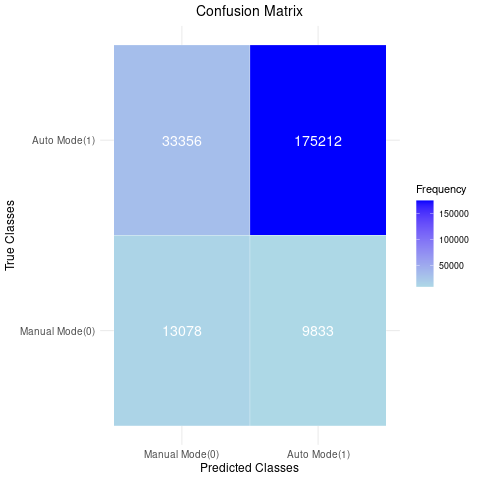

In [9]:
%%R
# Load required libraries
library(ggplot2)
library(caret)

# Map the values to labels (1 -> "Auto_mode", 0 -> "Manual")
predicted_classes_labeled <- factor(predicted_classes, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))
actual_classes_labeled <- factor (test_data$binaryDrivingMode, levels = c(0,1), labels = c("Manual Mode(0)", "Auto Mode(1)"))

# Generate the confusion matrix
cm <- confusionMatrix(predicted_classes_labeled, actual_classes_labeled)
cm_table <- as.data.frame(cm$table)

# Rename columns for better understanding
colnames(cm_table) <- c("Actual", "Predicted", "Frequency")

# Create the colored confusion matrix plot
ggplot(cm_table, aes(x = Predicted, y = Actual, fill = Frequency)) +
  geom_tile(color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue", name = "Frequency") +
  geom_text(aes(label = Frequency), color = "white", size = 5) +
  labs(title = "Confusion Matrix", x = "Predicted Classes", y = "True Classes") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, size = 14),
        axis.title = element_text(size = 12),
        axis.text = element_text(size = 10))

Area under the curve: 0.7383


Setting levels: control = 0, case = 1
Setting direction: controls < cases


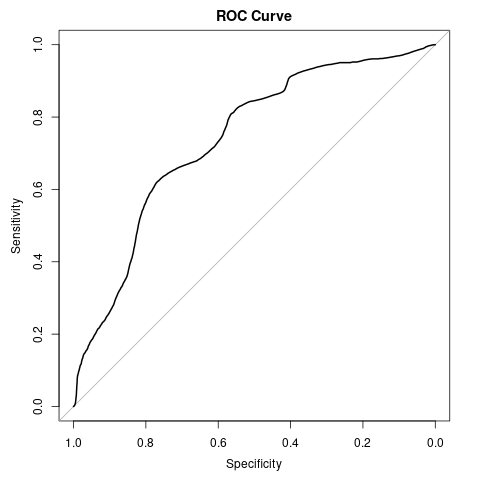

In [10]:
%%R

library(pROC)
roc_obj <- roc(test_data$binaryDrivingMode, predictions)
plot(roc_obj, main = "ROC Curve")
auc(roc_obj)

In [11]:
%%R

#Manually calculating the confusion matrix values
TP <- 175212
FP <- 9833
FN <- 33356
TN <- 13078

# Calculate Metrics
accuracy <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)
#Print Metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall:", recall, "\n")

Accuracy: 0.8134215 
Precision: 0.9468616 
Recall: 0.8400713 


In [12]:
%%R

#Manually calculating the confusion matrix values
TP <- 175212
FP <- 9833
FN <- 33356
TN <- 13078

# Calculate Metrics
tpr <- TP / (TP + FN) # Sensitivity
tnr <- TN / (TN + FP) # Specificity 

# Calculate Balance Accuracy
balanced_accuracy <- (tpr + tnr) / 2

#Print results
print(paste("True Positive Rate (TPR):", round(tpr, 4)))
print(paste("True Negative Rate (TPR):", round(tnr, 4)))
print(paste("Balance Accuracy:", round(balanced_accuracy, 4)))

[1] "True Positive Rate (TPR): 0.8401"
[1] "True Negative Rate (TPR): 0.5708"
[1] "Balance Accuracy: 0.7054"


In [13]:
%%R
# Filter actual manual mode locations
actual_manual_mode <- test_data[test_data$binaryDrivingMode == 0, ]

# Extract actual manual mode coordinates
actual_latitudes <- actual_manual_mode$latitude
actual_longitudes <- actual_manual_mode$longitude

# Filter test data where the model predicted Manual Mode (0)
predicted_manual_mode <- test_data[predicted_classes == 0, ]

# Extract predicted manual mode coordinates
predicted_latitudes <- predicted_manual_mode$latitude
predicted_longitudes <- predicted_manual_mode$longitude

# Ensure both actual and predicted lists have the same length
min_length <- min(length(actual_latitudes), length(predicted_latitudes))
actual_latitudes <- actual_latitudes[1:min_length]
actual_longitudes <- actual_longitudes[1:min_length]
predicted_latitudes <- predicted_latitudes[1:min_length]
predicted_longitudes <- predicted_longitudes[1:min_length]

# Create a data frame with actual and predicted manual mode locations
manual_mode_comparison <- data.frame(
    actual_latitude = actual_latitudes,
    actual_longitude = actual_longitudes,
    predicted_latitude = predicted_latitudes,
    predicted_longitude = predicted_longitudes
)

# Display first few rows to verify
head(manual_mode_comparison)

  actual_latitude actual_longitude predicted_latitude predicted_longitude
1        39.35293        -82.13387           39.37798           -82.13511
2        39.35293        -82.13387           39.37798           -82.13511
3        39.35293        -82.13387           39.37798           -82.13511
4        39.35293        -82.13387           39.37798           -82.13511
5        39.35293        -82.13387           39.37798           -82.13511
6        39.35293        -82.13387           39.37803           -82.13513


In [14]:
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri

# Activate automatic pandas conversion
pandas2ri.activate()

# Convert R DataFrame to Pandas using the correct approach
manual_mode_comparison_r = robjects.globalenv["manual_mode_comparison"]
manual_mode_comparison_py = pandas2ri.rpy2py(manual_mode_comparison_r)

# Display first few rows
print(manual_mode_comparison_py.head())

# Rename dataframe for clarity
df = manual_mode_comparison_py

   actual_latitude  actual_longitude  predicted_latitude  predicted_longitude
1         39.35293        -82.133874           39.377982           -82.135113
2         39.35293        -82.133874           39.377982           -82.135113
3         39.35293        -82.133874           39.377982           -82.135113
4         39.35293        -82.133874           39.377982           -82.135113
5         39.35293        -82.133874           39.377982           -82.135113


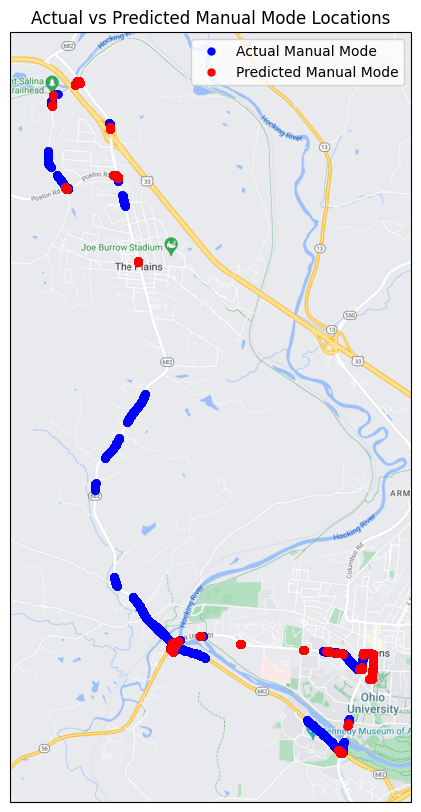

In [15]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
import matplotlib.pyplot as plt

# Define plot size
plt.figure(figsize=(10, 10))

# Get min and max latitude/longitude
minLat = df['actual_latitude'].min()
maxLat = df['actual_latitude'].max()
minLon = df['actual_longitude'].min()
maxLon = df['actual_longitude'].max()

# Define expansion coefficient to avoid edge cutoff
expansion_coeff = 0.005

# Load street map
street_map = GoogleTiles(style='street')

# Create plot with the street map
ax = plt.axes(projection=street_map.crs)
ax.set_extent(
    [minLon - expansion_coeff, maxLon + expansion_coeff,
     minLat - expansion_coeff, maxLat + expansion_coeff],
    ccrs.PlateCarree()
)

# Add map image
ax.add_image(street_map, 14)

# Extract actual and predicted manual mode locations
true_manual_lat = df['actual_latitude']
true_manual_lon = df['actual_longitude']

pred_manual_lat = df['predicted_latitude']
pred_manual_lon = df['predicted_longitude']

# Plot actual manual mode points (Blue)
plt.plot(true_manual_lon, true_manual_lat, 
         marker='o', ls='', color='blue', ms=5, 
         label='Actual Manual Mode', transform=ccrs.PlateCarree())

# Plot predicted manual mode points (Red)
plt.plot(pred_manual_lon, pred_manual_lat, 
         marker='o', ls='', color='red', ms=5, 
         label='Predicted Manual Mode', transform=ccrs.PlateCarree())

# Add title and legend
plt.title('Actual vs Predicted Manual Mode Locations')
plt.legend()

# Show the plot
plt.show()

In [16]:
%%R

## Define the selected GMID
selected_gmID <- "da853e0c-a10f-11ee-981c-d126ddbe9afa"

# Ensure the column exists in test_data
if (!("groupMetadataID.x" %in% colnames(test_data))) {
    stop("Error: Column 'groupMetadataID.x' does not exist in test_data.")
}

# Convert groupMetadataID.x to character to avoid type mismatches
test_data$groupMetadataID.x <- as.character(test_data$groupMetadataID.x)

# Filter test data for the selected GMID
test_data_gmid <- test_data[test_data$groupMetadataID.x == selected_gmID, ]

# Check if filtering was successful
if (nrow(test_data_gmid) == 0) {
    stop("Error: No data found for the selected GMID.")
}

# Confirm that only one GMID is present
print(unique(test_data_gmid$groupMetadataID.x))  # Should return only one GMID

# Check the number of rows
print(nrow(test_data_gmid))  # Should be greater than 0

[1] "da853e0c-a10f-11ee-981c-d126ddbe9afa"
[1] 23541


In [17]:
%%R

# Ensure predicted_classes is properly indexed for the same dataset
if (length(predicted_classes) != nrow(test_data)) {
    stop("Error: Length of predicted_classes does not match the number of rows in test_data.")
}

# Extract actual Manual Mode locations (Manual Mode = 0)
actual_manual_mode <- test_data_gmid[test_data_gmid$binaryDrivingMode == 0, ]

# Extract rows where predicted_classes == 0 for the selected GMID (Predicted Manual Mode)
predicted_manual_mode <- test_data_gmid[which(predicted_classes[test_data$groupMetadataID.x == selected_gmID] == 0), ]

# Confirm data selection
print(nrow(actual_manual_mode))  # Should be > 0 if successful
print(nrow(predicted_manual_mode))  # Should be > 0 if successful

[1] 2799
[1] 1812


In [18]:
%%R
# Extract actual Manual Mode coordinates
actual_latitudes <- actual_manual_mode$latitude
actual_longitudes <- actual_manual_mode$longitude

# Extract predicted Manual Mode coordinates
predicted_latitudes <- predicted_manual_mode$latitude
predicted_longitudes <- predicted_manual_mode$longitude

# Check for empty predicted values
if (length(predicted_latitudes) == 0 | length(predicted_longitudes) == 0) {
    stop("Error: No predicted manual mode locations found.")
}

# Ensure actual and predicted lists have the same length
min_length <- min(length(actual_latitudes), length(predicted_latitudes))

actual_latitudes <- actual_latitudes[1:min_length]
actual_longitudes <- actual_longitudes[1:min_length]
predicted_latitudes <- predicted_latitudes[1:min_length]
predicted_longitudes <- predicted_longitudes[1:min_length]

# Create a dataframe with actual and predicted locations
manual_mode_comparison <- data.frame(
    actual_latitude = actual_latitudes,
    actual_longitude = actual_longitudes,
    predicted_latitude = predicted_latitudes,
    predicted_longitude = predicted_longitudes
)

# Display first few rows
print(head(manual_mode_comparison))

  actual_latitude actual_longitude predicted_latitude predicted_longitude
1        39.35293        -82.13387           39.37798           -82.13511
2        39.35293        -82.13387           39.37798           -82.13511
3        39.35293        -82.13387           39.37798           -82.13511
4        39.35293        -82.13387           39.37798           -82.13511
5        39.35293        -82.13387           39.37798           -82.13511
6        39.35293        -82.13387           39.37803           -82.13513


In [19]:
%%R
# Store manual mode comparison dataframe in R global environment
manual_mode_comparison_r <- manual_mode_comparison

In [20]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Activate automatic conversion
pandas2ri.activate()

# Fetch the data from R
manual_mode_comparison_r = ro.globalenv['manual_mode_comparison']

# Convert R dataframe to pandas dataframe using updated method
df = pandas2ri.rpy2py(manual_mode_comparison_r)

# Check if dataframe transferred successfully
print(df.info())

# Check for NaN values
print(df.isna().sum())

# Fill missing values with column mean
df['predicted_latitude'].fillna(df['predicted_latitude'].mean(), inplace=True)
df['predicted_longitude'].fillna(df['predicted_longitude'].mean(), inplace=True)

# Verify all missing values are handled
print(df.isna().sum())  # Should show all zeros

<class 'pandas.core.frame.DataFrame'>
Index: 1812 entries, 1 to 1812
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   actual_latitude      1812 non-null   float64
 1   actual_longitude     1812 non-null   float64
 2   predicted_latitude   1812 non-null   float64
 3   predicted_longitude  1812 non-null   float64
dtypes: float64(4)
memory usage: 70.8+ KB
None
actual_latitude        0
actual_longitude       0
predicted_latitude     0
predicted_longitude    0
dtype: int64
actual_latitude        0
actual_longitude       0
predicted_latitude     0
predicted_longitude    0
dtype: int64


/tmp/ipykernel_23172/2726666904.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['predicted_latitude'].fillna(df['predicted_latitude'].mean(), inplace=True)
/tmp/ipykernel_23172/2726666904.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].

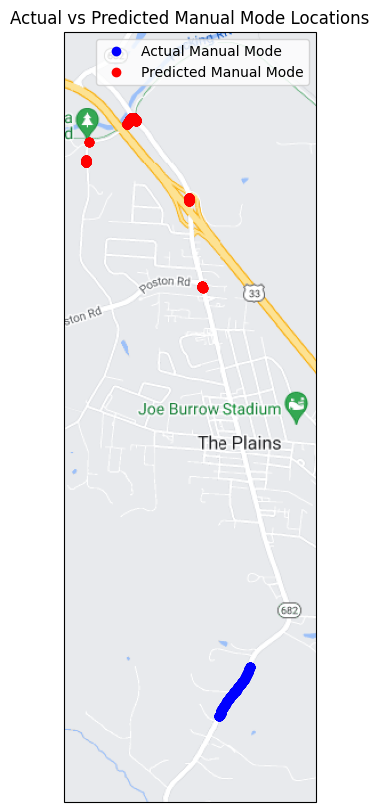

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

# Define plot size
plt.figure(figsize=(10, 10))

# Get min and max latitude/longitude
minLat = df['actual_latitude'].min()
maxLat = df['actual_latitude'].max()
minLon = df['actual_longitude'].min()
maxLon = df['actual_longitude'].max()

# Define expansion coefficient to avoid edge cutoff
expansion_coeff = 0.005

# Load street map
street_map = GoogleTiles(style='street')

# Create plot with the street map
ax = plt.axes(projection=street_map.crs)
ax.set_extent([minLon - expansion_coeff, maxLon + expansion_coeff,
               minLat - expansion_coeff, maxLat + expansion_coeff], ccrs.PlateCarree())

# Add map image
ax.add_image(street_map, 14)

# Plot actual manual mode points (Blue)
ax.plot(df['actual_longitude'], df['actual_latitude'], marker='o', ls='', color='blue',
        label='Actual Manual Mode', transform=ccrs.PlateCarree())

# Plot predicted manual mode points (Red)
ax.plot(df['predicted_longitude'], df['predicted_latitude'], marker='o', ls='', color='red',
        label='Predicted Manual Mode', transform=ccrs.PlateCarree())

# Add title and legend
plt.title('Actual vs Predicted Manual Mode Locations')
plt.legend()

# Show the plot
plt.show()

In [15]:
%%R

# Filter data where the actual driving mode was Auto Mode (1)
actual_auto_mode <- df_merged %>%
  filter(binaryDrivingMode == 1)

# Extract actual latitude and longitude
actual_latitudes <- actual_auto_mode$latitude
actual_longitudes <- actual_auto_mode$longitude

In [16]:
%%R

# Filter test data where the model predicted Auto Mode (1)
predicted_auto_mode <- test_data[predicted_classes == 1,]

# Extract predicted latitude and longitude
predicted_latitudes <- predicted_auto_mode$latitude
predicted_longitudes <- predicted_auto_mode$longitude

In [17]:
%%R
# Ensuring actual_longitudes has the same length as actual_latitudes
actual_longitudes <- actual_longitudes[1:length(actual_latitudes)]

In [18]:
%%R
# Ensure actual data is filtered properly to match predictions
actual_auto_mode <- test_data[test_data$binaryDrivingMode == 1, ]

# Extract matched actual coordinates
actual_latitudes <- actual_auto_mode$latitude
actual_longitudes <- actual_auto_mode$longitude

# Ensure both actual and predicted lists have the same length
min_length <- min(length(actual_latitudes), length(predicted_latitudes))

actual_latitudes <- actual_latitudes[1:min_length]
actual_longitudes <- actual_longitudes[1:min_length]
predicted_latitudes <- predicted_latitudes[1:min_length]
predicted_longitudes <- predicted_longitudes[1:min_length]

In [19]:
%%R

auto_mode_comparison <- data.frame(
  actual_latitude = actual_latitudes,
  actual_longitude = actual_longitudes,
  predicted_latitude = predicted_latitudes,
  predicted_longitude = predicted_longitudes
)

# Display first few rows to verify
head(auto_mode_comparison)

  actual_latitude actual_longitude predicted_latitude predicted_longitude
1        39.33799        -82.13558           39.33799           -82.13558
2        39.33799        -82.13558           39.33799           -82.13558
3        39.33799        -82.13558           39.33799           -82.13558
4        39.33799        -82.13558           39.33799           -82.13558
5        39.33799        -82.13558           39.33799           -82.13558
6        39.33799        -82.13558           39.33799           -82.13558


In [20]:
import rpy2.robjects as robjects
import pandas as pd
from rpy2.robjects import pandas2ri

# Activate automatic pandas conversion
pandas2ri.activate()

# Convert R DataFrame to Pandas using the correct approach
auto_mode_comparison_r = robjects.globalenv["auto_mode_comparison"]
auto_mode_comparison_py = pandas2ri.rpy2py(auto_mode_comparison_r)

# Display first few rows
print(auto_mode_comparison_py.head())

   actual_latitude  actual_longitude  predicted_latitude  predicted_longitude
1        39.337985        -82.135579           39.337985           -82.135579
2        39.337985        -82.135579           39.337985           -82.135579
3        39.337985        -82.135579           39.337985           -82.135579
4        39.337985        -82.135579           39.337985           -82.135579
5        39.337985        -82.135579           39.337985           -82.135579


(185045, 4)


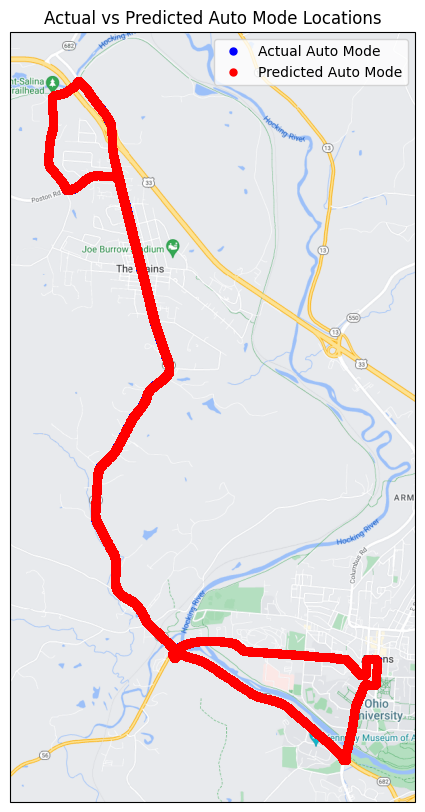

In [21]:
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
import matplotlib.pyplot as plt

# Define the dataframe (renaming for clarity)
df = auto_mode_comparison_py  # Use the dataframe converted from R

# Print shape for verification
print(df.shape)

# Define plot size
plt.figure(figsize=(10, 10))

# Get min and max latitude and longitude
minLat = df['actual_latitude'].min()
maxLat = df['actual_latitude'].max()
minLon = df['actual_longitude'].min()
maxLon = df['actual_longitude'].max()

# Define expansion coefficient to avoid edge cutoff
expansion_coeff = 0.005

# Load street map
street_map = GoogleTiles(style='street')

# Create plot with the street map
ax = plt.axes(projection=street_map.crs)
ax.set_extent(
    [minLon - expansion_coeff, maxLon + expansion_coeff, 
     minLat - expansion_coeff, maxLat + expansion_coeff], 
    ccrs.PlateCarree()
)

# Add map image
ax.add_image(street_map, 14)

# Extract actual and predicted auto mode locations
true_auto_lat = df['actual_latitude']
true_auto_lon = df['actual_longitude']

pred_auto_lat = df['predicted_latitude']
pred_auto_lon = df['predicted_longitude']

# Plot actual auto mode points (Blue)
plt.plot(true_auto_lon, true_auto_lat, 
         marker='o', ls='', color='blue', ms=5, 
                  label='Actual Auto Mode', transform=ccrs.PlateCarree())

# Plot predicted auto mode points (Red)
plt.plot(pred_auto_lon, pred_auto_lat, 
         marker='o', ls='', color='red', ms=5, 
         label='Predicted Auto Mode', transform=ccrs.PlateCarree())

# Add title and legend
plt.title('Actual vs Predicted Auto Mode Locations')
plt.legend()

# Show the plot
plt.show()